In [1]:
import ta_functions as ta
import yfinance as yf
import pandas as pd
import numpy as np

from scipy.stats import norm

from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline

from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configuration
TICKER = "TSLA"
YEARS_OF_DATA = 3
PROFIT_TARGET = 0.05
STOP_LOSS = 0.04
FORWARD_DAYS = 14 # For prediction
future_window = 14  # Backtesting

tolerance = 1.09

# Time window
end_date = datetime.now()
start_date = end_date - timedelta(days=365 * YEARS_OF_DATA)

# Shared model components
FEATURES = ['RSI', 'RSI_SMA', 'SMA1', 'SMA2', 'SMA3', 'SMA_Ratio', 'MACD', 'Signal_Line', 'Upper_Band', 'Lower_Band', 'Volume_MA20',
            '5_day_return', '10_day_return', 'Volatility', 'CCI', 'OBV', '+DI', '-DI', 'ADX', 'ATR', 
            'VWMA', 'VI+','VI+', 'KCu','KCl', 'STu', 'STl', 'Candlesticks',
           'Bear', 'Bull', 'vSpike', 'DD']

results = []

In [ ]:
# Functions
def get_stock_data(ticker, start_date, end_date):
    #print("Getting data for:   ", ticker)
    df = yf.download(ticker, start=start_date, end=end_date + timedelta(days=1), 
                     interval='1d', auto_adjust=False, progress=False)
    df = df.reset_index()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
    df.dropna()
    return df

def add_technical_indicators(df):
    df['SMA1'] = df['Close'].rolling(window=12).mean()
    df['SMA2'] = df['Close'].rolling(window=24).mean()
    df['SMA3'] = df['Close'].rolling(window=52).mean()
    df['SMA_Ratio'] = df['SMA1'] / df['SMA2']
    
    df['Bear'] = (df['SMA1'] < df['SMA2']).astype(int)
    df['Bull'] = (df['SMA2'] < df['SMA1']).astype(int)
    df['RSI']= ta.calculate_rsi(df)
    df['RSI_SMA'] = df['RSI'] / df['RSI'].rolling(14).mean()
    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=24, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['Upper_Band'] = df['SMA1'] + (2 * df['Close'].rolling(20).std())
    df['Lower_Band'] = df['SMA1'] - (2 * df['Close'].rolling(20).std())
    df['Volume_MA20'] = df['Volume'].rolling(window=20).mean()
    df['vSpike'] = (df['Volume'] > 2 * df['Volume_MA20']).astype(int)
    
    df['CCI'] = ta.calculate_cci(df)
    df['OBV'] = ta.calculate_obv(df)
    df[['+DI', '-DI', 'ADX']] = ta.calculate_dmi(df, n=14)
    df['ATR'] = ta.calculate_atr(high=df.High, low=df.Low, close=df.Close)
    
    df['VWMA'] = ta.calculate_vwma(df)
    df[['KCm', 'KCu', 'KCl']] = ta.calculate_keltner(df)
    df[['VI+', 'VI-']] = ta.calculate_vortex(df)
    df[['STu', 'STl']] = ta.calculate_supertrend(df)
    
    df = ta.add_candlestickpatterns(df)
    
    df['DD'] = df['Close'].where(df['Close'] < df['Close'].shift(1)).std()

    df['5_day_return'] = df['Close'].pct_change(5)
    df['10_day_return'] = df['Close'].pct_change(10)
    df['Volatility'] = df['Close'].rolling(14).std()
    
    return df

def compute_expected_return(df):
    df['5_day_return'] = df['Close'].pct_change(int(FORWARD_DAYS/2))
    df['10_day_return'] = df['Close'].pct_change(FORWARD_DAYS)
    df['Volatility'] = df['Close'].rolling(FORWARD_DAYS).std()
    df['Expected_Return'] = np.nan
    close_prices = df['Close'].values
    for i in range(len(close_prices) - FORWARD_DAYS):
        current_price = close_prices[i]
        future_max = np.nanmax(close_prices[i + 1:i + 1 + FORWARD_DAYS])
        expected_return = (future_max - current_price) / current_price
        df.iloc[i, df.columns.get_loc('Expected_Return')] = expected_return
    return df

def compute_expected_loss(df):
    df['Expected_Loss'] = np.nan
    close_prices = df['Close'].values
    for i in range(len(close_prices) - FORWARD_DAYS):
        current_price = close_prices[i]
        future_min = np.nanmin(close_prices[i + 1:i + 1 + FORWARD_DAYS])
        expected_loss = (future_min - current_price) / current_price
        df.iloc[i, df.columns.get_loc('Expected_Loss')] = expected_loss
    return df

def add_lagged_features(df, lags=[1, 2, 3]):
    for lag in lags:
        for feature in FEATURES:
            if feature in df.columns:
                df[f"{feature}_lag{lag}"] = df[feature].shift(lag)
    return df

def initialize_XGBR():
    model = XGBRegressor(
        n_estimators=200,
        max_depth=7,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42
    )
    return model
def label_tp_hit(df, window=14, profit_target=0.03, stop_loss=0.03):
    """
    Label each row:
    1 = TP hit before SL
    0 = SL hit before TP or neither hit
    """
    labels = []
    close_prices = df['Close'].values

    for i in range(len(close_prices) - window):
        current_price = close_prices[i]
        tp = current_price * (1 + profit_target)
        sl = current_price * (1 - stop_loss)
        future_prices = close_prices[i + 1:i + 1 + window]

        tp_hit_idx = next((j for j, price in enumerate(future_prices) if price >= tp), None)
        sl_hit_idx = next((j for j, price in enumerate(future_prices) if price <= sl), None)

        if tp_hit_idx is not None and (sl_hit_idx is None or tp_hit_idx < sl_hit_idx):
            labels.append(1)
        else:
            labels.append(0)

    # Fill remaining with NaN to keep alignment
    labels += [np.nan] * window
    df['TP_Hit_Label'] = labels
    return df

def compute_optimal_entry(df, forward_days=10, profit_target=0.05, stop_loss=-0.03):
    optimal_entries = []
    
    for i in range(len(df) - forward_days):
        entry_price = df['Close'].iloc[i]
        future_data = df.iloc[i+1:i+1+forward_days]
        
        min_price = future_data['Low'].min()  # Best possible entry
        max_price = future_data['High'].max()  # Highest possible gain

        # Check if TP or SL hit
        tp_price = entry_price * (1 + profit_target)
        sl_price = entry_price * (1 + stop_loss)

        tp_hit = (future_data['High'] >= tp_price).any()
        sl_hit = (future_data['Low'] <= sl_price).any()

        if tp_hit and not sl_hit:
            optimal_entry = min_price  # You had time to enter lower before TP
        elif sl_hit and not tp_hit:
            optimal_entry = entry_price  # Didn't get a better chance
        elif tp_hit and sl_hit:
            # Whichever came first
            first_tp_idx = future_data[future_data['High'] >= tp_price].index[0]
            first_sl_idx = future_data[future_data['Low'] <= sl_price].index[0]
            optimal_entry = min_price if first_tp_idx < first_sl_idx else entry_price
        else:
            optimal_entry = entry_price  # No TP/SL hit, assume flat

        optimal_entries.append(optimal_entry)

    # Align with DataFrame length
    df['Optimal_Entry'] = [np.nan]*forward_days + optimal_entries
    return df

def compute_expected_entry(df, n=3):
    df['Expected_Entry'] = df['Low'].rolling(window=n, min_periods=1).min().shift(-n)
    return df
    
def label_tp_hit(df, window=14, profit_target=0.03, stop_loss=0.03):
    """
    Label each row:
    1 = TP hit before SL
    0 = SL hit before TP or neither hit
    """
    labels = []
    close_prices = df['Close'].values

    for i in range(len(close_prices) - window):
        current_price = close_prices[i]
        tp = current_price * (1 + profit_target)
        sl = current_price * (1 - stop_loss)
        future_prices = close_prices[i + 1:i + 1 + window]

        tp_hit_idx = next((j for j, price in enumerate(future_prices) if price >= tp), None)
        sl_hit_idx = next((j for j, price in enumerate(future_prices) if price <= sl), None)

        if tp_hit_idx is not None and (sl_hit_idx is None or tp_hit_idx < sl_hit_idx):
            labels.append(1)
        else:
            labels.append(0)

    # Fill remaining with NaN to keep alignment
    labels += [np.nan] * window
    df['TP_Hit_Label'] = labels
    return df


[*********************100%***********************]  1 of 1 completed



=== Regression Model Evaluation ===
R2 Score: 0.6624
RMSE: 0.0944

=== Live Signal (Latest Data) ===
Date: 2025-06-25
Current Price: 325.36
Predicted Max Return (Next 20d): 12.29%
Take Profit: 341.63
Stop Loss: 309.09
>> Suggested Action: ✅ Consider Entry (Expected Return >= 3%)


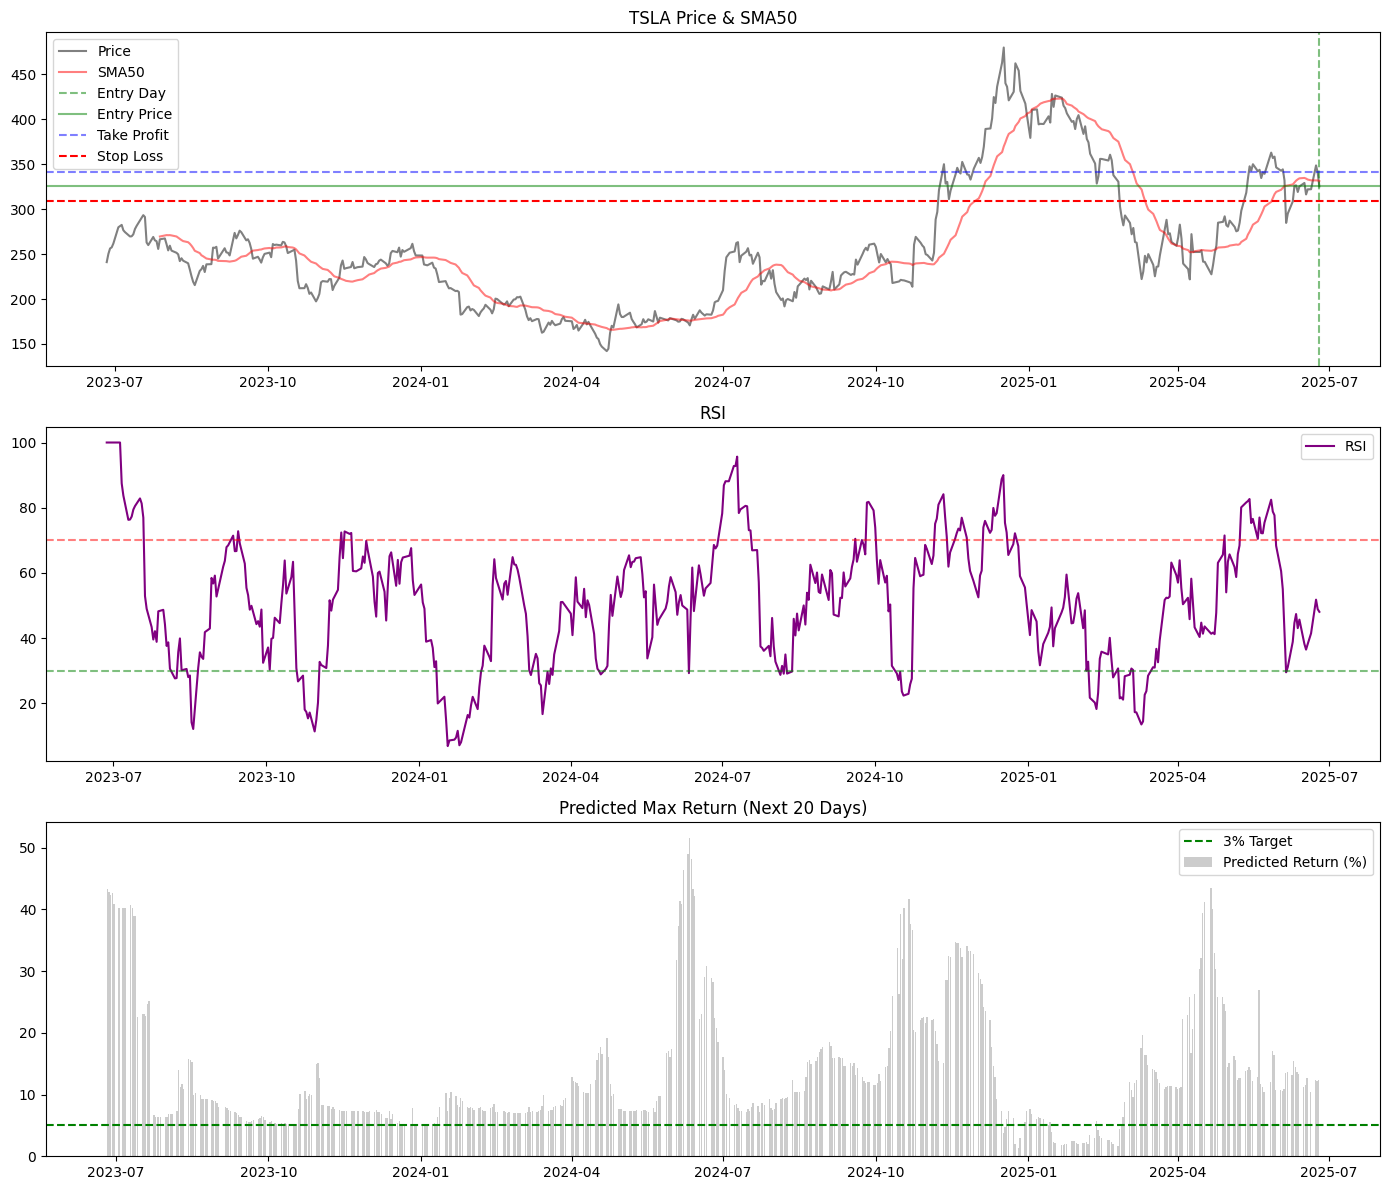

In [3]:
def get_stock_data(ticker, start_date, end_date):
    df = yf.download(ticker, start=start_date, end=end_date + timedelta(days=1), interval='1d', auto_adjust=False)
    df = df.reset_index()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
    return df

def add_technical_indicators(df):
    df['SMA1'] = df['Close'].rolling(window=12).mean()
    df['SMA2'] = df['Close'].rolling(window=24).mean()
    df['SMA3'] = df['Close'].rolling(window=52).mean()
    df['Bear'] = (df['SMA1'] < df['SMA2']).astype(int)
    df['Bull'] = (df['SMA2'] < df['SMA1']).astype(int)
    df['RSI']= ta.calculate_rsi(df)
    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=24, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['Upper_Band'] = df['SMA1'] + (2 * df['Close'].rolling(20).std())
    df['Lower_Band'] = df['SMA1'] - (2 * df['Close'].rolling(20).std())
    df['Volume_MA20'] = df['Volume'].rolling(window=20).mean()
    df['vSpike'] = (df['Volume'] > 2 * df['Volume_MA20']).astype(int)
    
    df['CCI'] = ta.calculate_cci(df)
    df['OBV'] = ta.calculate_obv(df)
    df[['+DI', '-DI', 'ADX']] = ta.calculate_dmi(df, n=14)
    df['ATR'] = ta.calculate_atr(high=df.High, low=df.Low, close=df.Close)
    
    df['VWMA'] = ta.calculate_vwma(df)
    df[['KCm', 'KCu', 'KCl']] = ta.calculate_keltner(df)
    df[['VI+', 'VI-']] = ta.calculate_vortex(df)
    df[['STu', 'STl']] = ta.calculate_supertrend(df)
    
    df = ta.add_candlestickpatterns(df)
    
    df['DD'] = df['Close'].where(df['Close'] < df['Close'].shift(1)).std()

    df['5_day_return'] = df['Close'].pct_change(5)
    df['10_day_return'] = df['Close'].pct_change(10)
    df['Volatility'] = df['Close'].rolling(14).std()
    
    return df

def compute_expected_return(df, forward_days=20):
    df = df.copy()
    df['Expected_Return'] = np.nan
    close_prices = df['Close'].values

    for i in range(len(close_prices) - forward_days):
        current_price = close_prices[i]
        future_max = np.nanmax(close_prices[i + 1:i + 1 + forward_days])
        expected_return = (future_max - current_price) / current_price
        df.iloc[i, df.columns.get_loc('Expected_Return')] = expected_return

    return df

def build_model_and_predict(data):
    features = ['RSI', 'SMA1', 'SMA2', 'SMA3', 'MACD', 'Signal_Line',
            'Upper_Band', 'Lower_Band', 'Volume_MA20',
            '5_day_return', '10_day_return', 'Volatility',
            'CCI', 'OBV', '+DI', '-DI', 'ADX', 'ATR', 
            'VWMA', 'VI+','VI+', 'KCu','KCl', 'STu', 'STl', 'Candlesticks',
           'Bear', 'Bull', 'vSpike', 'DD']


    df_model = data.dropna(subset=features + ['Expected_Return'])
    X = df_model[features]
    y = df_model['Expected_Return']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = RandomForestRegressor(n_estimators=200, random_state=42, max_depth=5)
    model.fit(X_train_scaled, y_train)

    print("\n=== Regression Model Evaluation ===")
    y_pred = model.predict(X_test_scaled)
    print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")

    # Full prediction for plotting
    data['Predicted_Return'] = model.predict(scaler.transform(data[features].fillna(0)))

    return model, scaler, features, data

if __name__ == "__main__":
    try:
        end_date = datetime.now()
        start_date = end_date - timedelta(days=365 * YEARS_OF_DATA)
        data = get_stock_data(TICKER, start_date, end_date)
        data['Volume'] = pd.to_numeric(data['Volume'], errors='coerce')

        data = add_technical_indicators(data)
        data = compute_expected_return(data)

        model, scaler, features, data = build_model_and_predict(data)

        # Live prediction
        latest = data.iloc[[-1]]
        latest_scaled = scaler.transform(latest[features].fillna(0))
        live_prediction = model.predict(latest_scaled)[0]

        entry_price = latest['Close'].values[0]
        take_profit = entry_price * (1 + PROFIT_TARGET)
        stop_loss = entry_price * (1 - STOP_LOSS)

        print("\n=== Live Signal (Latest Data) ===")
        print(f"Date: {latest.index[-1].date()}")
        print(f"Current Price: {entry_price:.2f}")
        print(f"Predicted Max Return (Next {FORWARD_DAYS}d): {live_prediction*100:.2f}%")
        print(f"Take Profit: {take_profit:.2f}")
        print(f"Stop Loss: {stop_loss:.2f}")

        if live_prediction >= PROFIT_TARGET:
            print(">> Suggested Action: ✅ Consider Entry (Expected Return >= 3%)")
        else:
            print(">> Suggested Action: 🚫 No Entry (Expected Return Too Low)")

        # === Plotting ===
        plt.figure(figsize=(14, 12))

        # Subplot 1: Price + SMA2
        plt.subplot(3, 1, 1)
        plt.plot(data['Close'], label='Price', color='gray')
        plt.plot(data['SMA2'], label='SMA50', color='red', alpha = 0.5)
        plt.title(f'{TICKER} Price & SMA50')

        # Plot entry signal and thresholds
        entry_date = latest.index[-1]
        plt.axvline(entry_date, color='green', linestyle='--', label='Entry Day', alpha = 0.5)
        plt.axhline(entry_price, color='green', linestyle='-', label='Entry Price', alpha = 0.5)
        plt.axhline(take_profit, color='blue', linestyle='--', label='Take Profit', alpha = 0.5)
        plt.axhline(stop_loss, color='red', linestyle='--', label='Stop Loss')

        plt.legend()

        # Subplot 2: RSI
        plt.subplot(3, 1, 2)
        plt.plot(data['RSI'], label='RSI', color='purple')
        plt.axhline(70, linestyle='--', color='red', alpha=0.5)
        plt.axhline(30, linestyle='--', color='green', alpha=0.5)
        plt.title('RSI')
        plt.legend()

        # Subplot 3: Predicted Return
        plt.subplot(3, 1, 3)
        plt.bar(data.index, data['Predicted_Return'] * 100, color='gray', alpha=0.4, label='Predicted Return (%)')
        plt.axhline(PROFIT_TARGET * 100, color='green', linestyle='--', label='3% Target')
        plt.title('Predicted Max Return (Next 20 Days)')
        plt.legend()

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error: {e}")